<a href="https://colab.research.google.com/github/PingPingE/Learn_ML_DL/blob/main/Practice/Hands_On_ML/ch14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망을 사용한 컴퓨터 비전


# 합성곱 층
- 합성곱 층의 뉴런은 <strong>입력 이미지의 모든 픽셀에 연결되는 것이 아니라</strong>
- 합성곱 층 뉴런의 <strong>수용장 안에 있는 픽셀만</strong> 연결된다,
- <strong>계층적인 구조</strong>로 인해 저수준에서 고수준 특성으로 조합해나가도록 한다.

## 텐서플로 구현

- 텐서플로에서 각 입력 이미지는 보통 [높이, 너비, 채널] 형태의 3D 텐서로 표현된다.
- 하나의 미니배치는 [미니배치 크기, 높이, 너비, 채널] 형태의 4D 텐서로 표현된다.
- 합성곱 층의 가중치는 [f_h, f_w, f_n', f_n] 형태의 4D 텐서로 표현된다.
- 합성곱 층의 편향은 간단하게 [f_n]형태의 1D 텐서로 나타낸다.


*f_n' : 이전 층의 피처맵 수(input channel)

### 데이터 로드

In [ ]:
from sklearn.datasets import load_sample_image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#로드 및 정규화
china= load_sample_image("china.jpg")/255
flower= load_sample_image("flower.jpg")/255


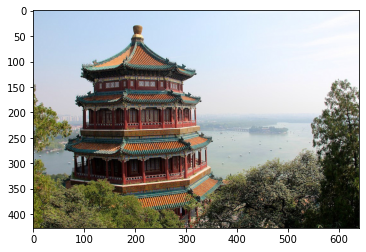

In [ ]:
plt.imshow(china)

In [ ]:
china.shape

(427, 640, 3)

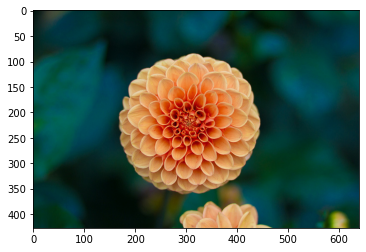

In [ ]:
plt.imshow(flower)

In [ ]:
flower.shape

(427, 640, 3)

In [ ]:
images=np.array([china,flower]) #입력으로 넣기 위해 합쳐서 4D 텐서로 만들기
batch_size, height, weight, channels = images.shape

In [ ]:
images.shape

(2, 427, 640, 3)

### 두 개의 7*7 필터 만들기

In [ ]:
#필터 2개 만들기
filters=np.zeros(shape=(7,7,channels, 2), dtype=np.float32)
filters[:, 3, :, 0] =1 #수직선
filters[3,:,:,1]=1 #수평선

In [ ]:
filters.shape

(7, 7, 3, 2)

In [ ]:
outputs=tf.nn.conv2d(images, filters, strides=1, padding="SAME") #제로 패딩 사용

<function matplotlib.pyplot.show>

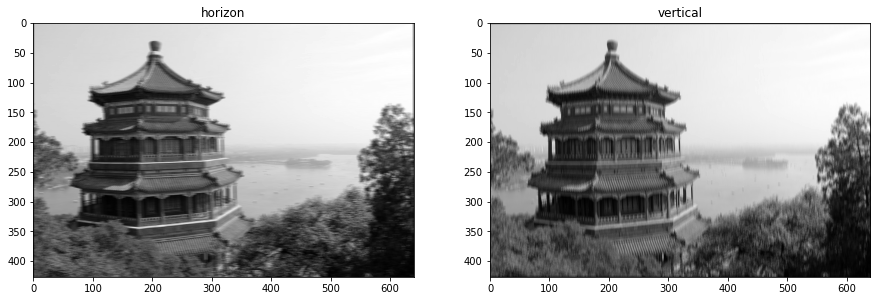

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title("horizon")
plt.imshow(outputs[0,:,:,1], cmap="gray") 
plt.subplot(1,2,2)
plt.title("vertical")
plt.imshow(outputs[0,:,:,0], cmap="gray")
plt.show

------------
오른쪽 이미지를 보면, 왼쪽보다 수직선이 좀 더 강조된 것을 알 수 있다.

<function matplotlib.pyplot.show>

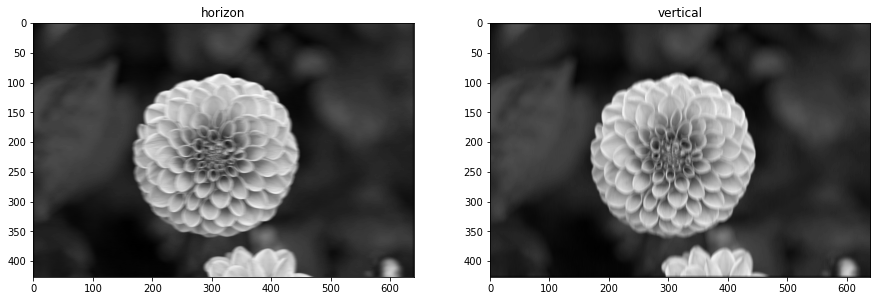

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title("horizon")
plt.imshow(outputs[1,:,:,1], cmap="gray") 
plt.subplot(1,2,2)
plt.title("vertical")
plt.imshow(outputs[1,:,:,0], cmap="gray")
plt.show

### 케라스로 필터 학습
- 앞에서는 수동으로 필터를 직접 정의했지만, 실제 CNN에서는 보통 <strong>훈련 가능한 변수</strong>로 필터를 정의한다.
- 따라서 <strong>신경망이 가장 잘 맞는 필터를 찾기 위해 학습</strong>할 수 있는 것이다.

In [ ]:
from tensorflow import keras
conv =keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')

### 메모리 요구 사항
- CNN과 관련된 문제 중 하나는, 합성곱 층이 <strong>많은 양의 RAM</strong>을 필요로 한다는 것
- 특히 훈련하는 동안 <strong>역전파 알고리즘이 역방향 계산을 할 때 정방향에서의 모든 계산 값(중간 값)을 필요</strong>로 하기 때문
  - ex) input: 150 x 100 x 3 / filters: 200 / kernel_size: 5 /  strides:  1 / padding : 'same' 인 합성곱 층<br> => 파라미터 수: (5 x 5 x 3+1(편향)) x 200 = 15,200개
<br><br>
  => 완전 연결 층에 비해선 파라미터 수가 적지만, 200개의 특성 맵마다 150 x 100개의 뉴런을 포함하고, 각 뉴런은 5 x 5 x 3 = 75 개의 입력에 대한 가중치 합을 계산해야한다. 따라서 총 <strong>2억 2천 5백만 번 의 실수 곱셈이 필요(5 x 5 x 3 x 150 x 100 x 200) </strong>

- 만약 특성 맵이 32비트 부동소수로 표현된다면, 200 x 150 x 100 x 32= 9600만 비트(약 12MB) <br>  => 한 샘플에 대해서임(훈련 배치가 100이라면 해당 층은 1.2GB 차지)
  - <strong>훈련하는 동안</strong>에는 정방향에서 계산했던 모든 값이 보존되어야 하므로 <strong>각 층에서 필요한 RAM양의 전체 합</strong>만큼 필요
  - <strong>추론할 때</strong>에는 하나의 층이 점유하고 있는 RAM은 다음 층의 계산이 완료되자마자 해제 -> 따라서 <strong>연속된 두 개의 층에서 필요한 만큼만</strong> RAM 점유

# 풀링 층
- <strong>계산량과 메모리 사용량,파라미터 수를 줄이기 위해</strong> 입력 이미지의 <strong>부표본(즉, 축소본)</strong>을 만드는 것
- <strong>최대나 평균 같은 합산 함수</strong>를 사용해 입력값을 더하는 것이 전부(가중치가 없음)
- <strong>모든 입력 채널에 독립적으로 적용</strong>되므로 출력과 입력의 채널이 동일
- 또한, 최대 풀링은 <strong>작은 변화에도 일정 수준의 불변성</strong>을 만들어준다.
  - 의미 없는 것은 모두 제거하고 가장 큰 특징만 유지하기 때문(정보 손실)
  - 이와 같은 불변성은 '분류'작업처럼 작은 부분에서 영향을 받지 않는 경우는 유용할 수 있다.
  - 어떤 어플리케이션에는 이러한 불변성이 필요하지 않다.(시맨틱 분할 등)

## 공간 차원이 아닌 깊이 차원에서의 풀링
- 공간 차원이 아닌, 깊이(채널) 차원에서 풀링이 가능하다.(Depthwise)
- 이를 통해 <strong>다양한 특성에 대한 불변성</strong>을 학습할 수 있다.
- 즉, <strong>회전, 두께, 밝기, 왜곡, 색상 등 어떤 것에 대해서도 불변성을 학습</strong>할 수 있다.

## 텐서플로 구현

- Maxpooling

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2) #strides의 기본값은 커널 크기

- AveragePooling

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

--------------------
Avgpooling은 
- Maxpooling보다 정보 손실은 적다.
- 하지만 보통 Maxpooling이 성능이 더 좋다.(이동 불변성 제공, 낮은 연산 비용) 


### 깊이 방향 풀링 층
- 케라스는 깊이 방향 풀링 층을 제공하지 않지만, 텐서플로 저수준 딥러닝 API를 사용할 수 있다.
- tf.nn.max_pool()함수를 사용
- 커널 크기와 스트라이드를 <strong>4개의 원소</strong>를 가진 튜플로 지정한다.
- 이 때, <strong>4개의 원소 중 앞쪽의 세 값은 1</strong>이어야 한다.
  - <strong>배치, 높이, 너비 차원을 따라 커널크기와 스트라이드가 1이라는 뜻</strong>
- 마지막 원소는 채널 차원에서의 스트라이드 => 입력 차원이 해당 값과 나누어 떨어져야한다.

In [ ]:
images=tf.random.uniform((150,100,30,90))
images.shape

TensorShape([150, 100, 30, 90])

In [ ]:
output= tf.nn.max_pool(images, ksize=(1,1,1,3), strides=(1,1,1,3), padding='VALID') #커널 크기와 스트라이드 튜플의 세 값은 1, 마지막 3은 채널 차원

- 케라스 모델의 층으로 사용하고 싶으면 Lambda층으로 감싼다.(또는 사용자 정의 케라스 층을 만든다.)

In [ ]:
depth_pool = keras.layers.Lambda(
    lambda x: tf.nn.max_pool(x, ksize=(1,1,1,3), strides=(1,1,1,3), padding='valid')
)

- Global Average Pooling
  - 각 특성맵의 평균을 계산한다.
  - 각 샘플의 특성 맵마다 하나의 숫자를 출력한다.
  - 매우 파괴적인 연산이지만, 마지막 <strong>출력층</strong>에는 유용할 수 있다.

  <img src="https://alexisbcook.github.io/assets/global_average_pooling.png" width=50%  height=50%/>
  

In [ ]:
global_avg_pool=keras.layers.GlobalAvgPool2D()

# CNN 구조
- 전형적인 CNN 구조는 <strong>합성곱과 풀링이 번갈아</strong> 나오면서 깊어진다.
- 네트워크를 통과할수록 이미지는 <strong>점점 작아지지만 더 많은 특성 맵</strong>을 가진다

TIP)
- 합성곱 층에 너무 큰 커널을 사용하는 것은 흔히 하는 실수이다.
- 예를 들어, <strong>5 * 5 커널의 합성곱 층 대신 3 * 3커널 두 개</strong>를 쌓는 것이 파라미터와 계산량이 더 적다.
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FT5kb2%2FbtqwonLQrNm%2Fd56nskDXEYoCWRDpxxkeAK%2Fimg.png" width=50% height=50%/>
- <strong>한 가지 예외는 첫 번째 층</strong>이다. 
  - 첫 번째 층에는 보통 큰 크기의 kernel(보통 3 * 3 이상)과 2 이상의 stride를 사용한다.
  - <strong>너무 많은 정보를 잃지 않고 공간 방향 차원을 줄일 수 있기 때문</strong>
  - 또한, 어차피 input은 채널 수도 적으므로 비용이 크게 들지 않는다.  


In [ ]:
model = keras.models.Sequential([
                                 keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28,28,1]),#그레이 스케일 이미지를 받을 거라서 채널 1
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
                                 keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
                                 keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(128, activation='relu'),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(64, activation='relu'),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(10, activation='softmax')                                 
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)         5

## 케라스를 사용해 ResNet-34 CNN 구현하기

- ResNet은 ILSVRC 2015대회에서 승리한 모델로, 152개 층으로 구성된 극도로 깊은 CNN을 사용했다.(34,50,101개 층도 있다)
- 해당 모델은 <strong>더 적은 파라미터를 사용해서 점점 더 깊은 네트워크</strong>로 모델을 구성하는 일반적인 트렌드를 만들었다.
- 이런 깊은 네트워크를 훈련시킬 수 있는 핵심 요소는 <strong>'스킵 연결'(또는 '숏컷 연결')</strong>이다.
  <img src="https://miro.medium.com/max/945/1*tbBd-5P2HdhSYF_PMU7mVQ.png"/>
- 즉, 입력 신호가 <strong>다음 층의 출력에도 더해진다.</strong>
  - 입력 신호가 네트워크 전체에 영향을 미칠 수 있다.(값을 끝까지 살릴 수 있다.)
  - 즉 <strong>역전파를 수행할 때 값이 소실되는 현상</strong>을 막을 수 있다.
  - 기존에는 목적 함수 H(x)가 특정 y가 되도록(H(x)-y=0이 되도록) 학습하는 것이 목표이지만, <br> 입력 x를 출력에 더함으로써<strong> H(x)-x(잔차, F(x))를 학습</strong>하게 된다.
    - 즉, 이 잔차를 학습한다는 것은 <strong>결국 H(x)가 x가 되도록</strong> 학습한다는 것 = <strong>목적함수가 항등 함수</strong> = <strong>훈련 속도가 빨라진다.</strong>

참조) 
- 핸즈온 머신러닝 책
- [링크1](https://medium.com/humanscape-tech/paper-review-resnet-e768afd296bc)
- [링크2](https://ganghee-lee.tistory.com/41)
- [링크3](https://m.blog.naver.com/laonple/221259295035)



### ResidualUnit층


-  심층 잔차 네트워크는 <strong>스킵 연결을 가진 작은 신경망인 잔차 유닛(ResidualUnit)</strong>을 쌓은 것으로 볼 수 있다.

<img src="https://pytorch.org/assets/images/resnet.png"/>

In [ ]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False) #재사용할 함수(인자도 고정 가능)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

------------------
- [python docs-fucntools](https://docs.python.org/3/library/functools.html?highlight=functools#module-functools)
- functools 모듈의 partial함수를 통해 함수의 인자를 계속 바꿔주면서(고정도 가능) 함수를 재사용하게 한다. 


```
def partial(func, /, *args, **keywords): #====함수, 인자 전달(위치 , 키워드 인자 모두 포함)
    def newfunc(*fargs, **fkeywords):
        newkeywords = {**keywords, **fkeywords}
        return func(*args, *fargs, **newkeywords)
    newfunc.func = func
    newfunc.args = args
    newfunc.keywords = keywords
    return newfunc
```



In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## 케라스에서 제공하는 사전훈련된 모델 사용하기
- 일반적으로 표준 모델을 위와 같이 구현할 필요는 없다.
- <strong>keras.applications 패키지</strong>에 준비되어 있는 <strong>사전훈련된 모델</strong>을 코드 한 줄로 불러올 수 있다.

### 사전훈련된 모델 불러오기

In [ ]:
model=keras.applications.resnet50.ResNet50(weights="imagenet") #이미지넷 데이터셋으로 사전훈련된 모델의 가중치 다운로드

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

-----------
- 해당 모델을 사용하려면 224*224 크기의 이미지여야한다.


### 이미지 리사이즈
- 적재한 이미지 리사이즈 => <strong>tf.image.resize</strong>
- tf.image.resize 함수는 <strong>가로세로 비율</strong>을 유지하지 않는다. 
- 만약 비율이 중요하다면 crop후 resize하는 <strong>tf.image.crop_and_resize</strong>함수를 사용해본다.(데이터 증식 목적으로도 사용)

#### tf.image.resize

In [ ]:
def before_after_plot(before, after):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1).set_title("before")
  plt.imshow(before)
  plt.subplot(1,2,2).set_title("after")
  if len(after.shape)>3:
    origin=after.shape
    after = tf.reshape(after, [origin[1],origin[2],-1])
  plt.imshow(after)
  plt.show()

In [ ]:
len(flower.shape)

3

In [ ]:
resized_china=tf.image.resize(china, [224,224])
resized_flower = tf.image.resize(flower,[224,224])
#====한 번에 다 할거면
images=np.array([china, flower])
resized_images = tf.image.resize(images,[224,224])

In [ ]:
resized_china.shape

TensorShape([224, 224, 3])

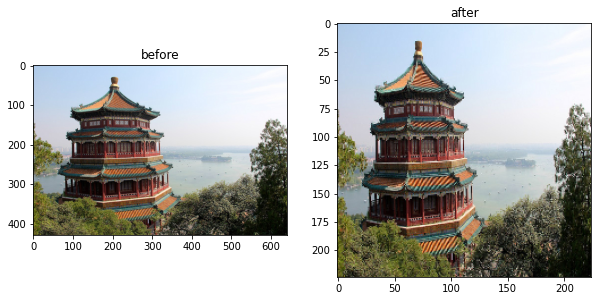

In [ ]:
before_after_plot(china, resized_china)

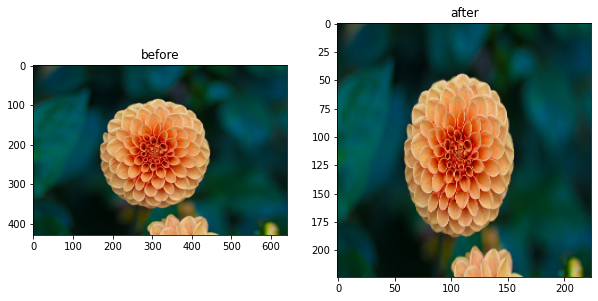

In [ ]:
before_after_plot(flower, resized_flower)

#### crop_and_resize
- 참고: [tf_docs](https://www.tensorflow.org/api_docs/python/tf/image/crop_and_resize)

In [ ]:
flower.shape

(427, 640, 3)

In [ ]:
boxes = tf.random.uniform(shape=(1,4)) #crop할 박스 좌표  [y1, x1, y2, x2] (일단 랜덤으로)
box_indices = [0] #각 box 좌표를 대입할 대상 이미지들 index(나는 batch_size=1이므로 걍 0, boxes도 어차피 한 개)
crop_size=(224,224)
print(boxes)
print(box_indices)
print(crop_size)

tf.Tensor([[0.05609715 0.9872415  0.03690612 0.47450066]], shape=(1, 4), dtype=float32)
[0]
(224, 224)


In [ ]:
d_flower= tf.reshape(flower,[1,427,640,3]) #차원 조절하고 적용해야함

In [ ]:
d_flower.shape

TensorShape([1, 427, 640, 3])

In [ ]:
 resized_flower2 = tf.image.crop_and_resize(d_flower,boxes, box_indices, crop_size)

In [ ]:
resized_flower2.shape

TensorShape([1, 224, 224, 3])

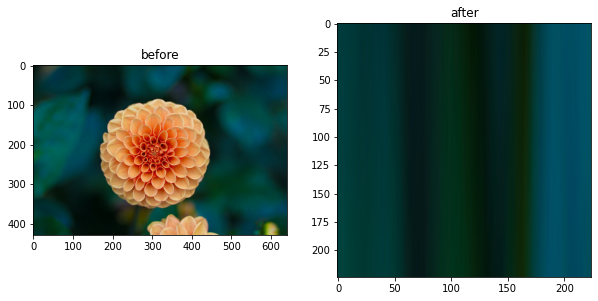

In [ ]:
before_after_plot(flower, resized_flower2)

### 전처리 적용 및 예측
- preprocess_input함수: 모델마다 이미지 전처리
- 단, 해당 함수는 픽셀값이 0~255사이라고 가정하므로 255를 다시 곱해줌

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(tf.Variable([resized_flower, resized_china])*255) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


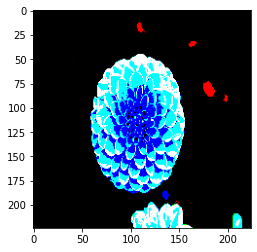

In [ ]:
plt.imshow(inputs[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


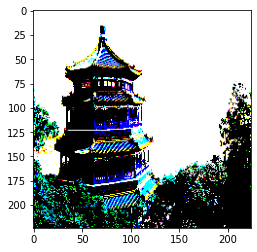

In [ ]:
plt.imshow(inputs[1])

In [ ]:
inputs.shape

TensorShape([2, 224, 224, 3])

- 예측 및 top 3결과 확인

In [ ]:
Y_proba=model.predict(inputs)

In [ ]:
Y_proba.shape #총 1000개의 클래스가 있으므로

(2, 1000)

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(inputs)):
  print(f"image: #{image_index}")
  for class_id, name, y_proba in top_K[image_index]:
    print(f" {class_id} - {name :12s} {y_proba*100:.2f}")
  print()

40960/35363 [==================================] - 0s 0us/step
image: #0
 n03530642 - honeycomb    49.83
 n13040303 - stinkhorn    33.95
 n02206856 - bee          4.35

image: #1
 n02825657 - bell_cote    82.35
 n03877845 - palace       6.75
 n03781244 - monastery    4.19



## 사전훈련된 모델을 사용한 전이 학습
- 훈련 데이터가 충분하지 않다면, 잘 알려진 사전훈련된 모델의 하위층을 사용하는 것이 좋다. 

### Xception모델 전이 학습

#### 데이터셋 로드

In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)#with_info=True면 데이터셋의 크기와 클래스 이름을 얻을 수 있다.

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [ ]:
dataset_size=info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [ ]:
print(dataset_size)
print(class_names)
print(n_classes)

3670
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5


---------------------
- 이 데이터셋에는 train세트만 있고 test나 validation세트는 없다.
- 따라서 train세트를 나눠야한다. => TF 데이터셋에는 이를 위한 API가 제공된다. 

In [ ]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10,15,75])

AttributeError: ignored

----------
근데 위 API 없어짐
참고: [링크](https://www.inflearn.com/questions/35919)

In [ ]:
train_set, valid_set, test_set = tfds.load(
    name="tf_flowers", 
    split=['train[:75%]', 'train[75%:90%]', 'train[90%:]'],
    as_supervised=True)

-------
- 그냥 데이터셋 로드할 때 split에 바로 지정해주면됨

[split API 참고](https://www.tensorflow.org/datasets/splits)

In [ ]:
def count(x): #개수 return(더 효율적인 방법이 있겠지만 현재 생각나는 가장 간단한 방법...)
  n=0
  for item in x:
    n+=1
  return n

In [ ]:
print(count(train_set))
print(count(valid_set))
print(count(test_set))

2752
551
367


#### 전처리 함수

In [ ]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224,224])#resizing
  final_image = keras.applications.xception.preprocess_input(resized_image) #이미지 전처리 적용
  return final_image, label

----------
- 데이터 증식하려면 다음과 같은 함수를 추가할 수 있음
  - tf.image.random_crop(): 이미지 랜덤하게 자르기
  - tf.image.random_flip_left_right(): 이미지 수평으로 랜덤하게 뒤집기

#### 섞기 / 전처리 적용 / 프리페치

In [ ]:
batch_size=32
train_set=train_set.shuffle(1000)
train_set=train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set=valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set=test_set.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
count(train_set)

86

In [ ]:
2752//batch_size

86

In [ ]:
for x in train_set.take(1):
  print(x)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.9607842 , -0.95294106, -0.9994598 ],
         [-0.94947976, -0.9416366 , -0.98869544],
         [-0.93831515, -0.930472  , -0.97753084]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.9422968 , -0.93445367, -0.9815125 ],
         [-0.9285914 , -0.92074823, -0.96780705],
         [-0.9190476 , -0.91120446, -0.9582633 ]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.90868336, -0.9008402 , -0.94789904],
         [-0.89937973, -0.8915366 , -0.9385954 ],
         [-0.8952381 , -0.88739496, -0.93445

#### Xception모델 로드
- 불러올 때 include_top=False로 하면 최상층을 커스터마이징 할 수
 있다. 

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False) #=====최상층 안불러옴
#====커스터마이징
avg=keras.layers.GlobalAveragePooling2D()(base_model.output)
output= keras.layers.Dense(n_classes, activation="softmax")(avg) #우리 데이터셋의 class개수에 맞게

#keras.Model 클래스의 객체 생성
model = keras.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 0s 0us/step


#### 훈련 초기에 사전훈련된 층의 가중치 동결하기
- <strong>새로운 최상층이 랜덤하게 초기화</strong> 되어 있다. 
- 따라서 <strong>처음 몇 번의 에포크 동안 큰 오차</strong>를 만들 것이다.
- 이는 <strong>다른 재사용된 가중치 값을 이상하게 업뎃</strong>할 수 있다.
- 그래서 재사용된 가중치 값이 몇 번의 에포크동안 <strong>업뎃되지 않도록 </strong>가중치를 동결시킨다.

In [ ]:
for layer in base_model.layers:
  layer.trainable=False

-----------
base_model 객체 자체를 사용하는 것이 아니라, 기반 모델의 층을 직접 사용하므로 base_model.trainable=False로 하면 X

#### 모델 컴파일 및 훈련

In [ ]:
optimizer= keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history=model.fit(train_set, epochs=5, validation_data= valid_set)

Epoch 1/5
86/86 [==============================] - 17s 162ms/step - loss: 2.1322 - accuracy: 0.6807 - val_loss: 1.0923 - val_accuracy: 0.8566
Epoch 2/5
86/86 [==============================] - 13s 148ms/step - loss: 0.7616 - accuracy: 0.8832 - val_loss: 0.6621 - val_accuracy: 0.8784
Epoch 3/5
86/86 [==============================] - 13s 151ms/step - loss: 0.4004 - accuracy: 0.9240 - val_loss: 0.5233 - val_accuracy: 0.8802
Epoch 4/5
86/86 [==============================] - 13s 154ms/step - loss: 0.2076 - accuracy: 0.9534 - val_loss: 0.4269 - val_accuracy: 0.9074
Epoch 5/5
86/86 [==============================] - 14s 159ms/step - loss: 0.1265 - accuracy: 0.9651 - val_loss: 0.4071 - val_accuracy: 0.9002


In [ ]:
def result_plot(history):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.title('loss')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'],label='val')
  plt.legend()

  plt.subplot(1,2,2)
  plt.title("accuracy")
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'], label='val')
  plt.legend()
  plt.plot()

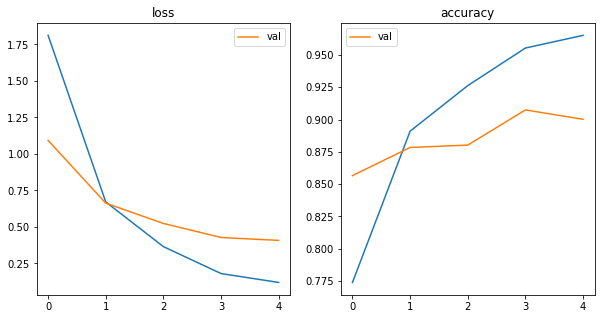

In [ ]:
result_plot(history)

- 이제 가중치 동결 해제

In [ ]:
for layer in base_model.layers:
  layer.trainable=True

In [ ]:
optimizer= keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001) #동결 해제 후에는 학습률 작게
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) #다시 컴파일
history=model.fit(train_set, epochs=5, validation_data= valid_set)

Epoch 1/5
86/86 [==============================] - 59s 619ms/step - loss: 0.5294 - accuracy: 0.8334 - val_loss: 0.5418 - val_accuracy: 0.8693
Epoch 2/5
86/86 [==============================] - 56s 649ms/step - loss: 0.0750 - accuracy: 0.9761 - val_loss: 0.3018 - val_accuracy: 0.9238
Epoch 3/5
86/86 [==============================] - 55s 639ms/step - loss: 0.0631 - accuracy: 0.9856 - val_loss: 0.2603 - val_accuracy: 0.9328
Epoch 4/5
86/86 [==============================] - 56s 647ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.2444 - val_accuracy: 0.9437
Epoch 5/5
86/86 [==============================] - 56s 650ms/step - loss: 0.0053 - accuracy: 0.9966 - val_loss: 0.3116 - val_accuracy: 0.9292


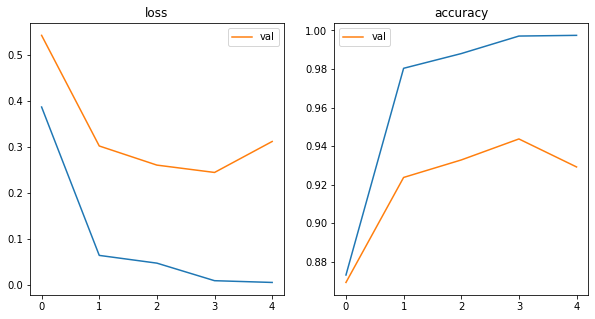

In [ ]:
result_plot(history)

### 분류와 위치 추정
- <strong>이미지에서 물체의 위치를 추정하는 것은 회귀 작업</strong>으로 정의할 수 있다.
- 물체 주위의 bounding box는 <strong>물체 중심의 수평, 수직 좌표와 높이, 너비</strong>를 예측하는 것이다. 
- 즉, 4개의 숫자를 예측하는 것(범위는 0~1사이로 정규화해야함)
- 따라서 4개의 유닛을 가진 dense layer를 추가하고 MSE손실을 사용해서 훈련할 수 있다.

In [ ]:
loc_output=keras.layers.Dense(4)(avg)
model2 = keras.Model(inputs=base_model.input, outputs=[output,loc_output]) #class 분류 결과와 위치 추정 결과 모두 받기
model2.compile(loss=['sparse_categorical_crossentropy', 'mse'], 
               loss_weights=[0.8,0.2],#====loss의 가중치(분류에 대한 loss를 더 많이 반영)
               optimizer=optimizer,
               metrics='accuracy')

----------
- 사실 MSE는 위 문제에서는 그리 좋은 지표가 아님
- 보통 IoU(Intersection over Union)를 많이 사용
- tf.keras.metrics.MeanIoU에 구현되어있음


<img src="https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png" width=30% height=30% />

# 연습문제
### 이미지 분류에서 완전 연결 DNN보다 CNN이 나은 점은?
  - 연속된 층이 <strong>부분적으로 연결</strong>되어 있고, 많은 가중치를 <strong>재사용</strong>한다는 점
    - DNN보다 적은 파라미터
    - DNN보다 빠른 속도
    - 과대적합의 위험을 줄임
    - 더 적은 훈련 데이터로도 가능
  - 이미지의 <strong>어느 위치에 있는 특성이라도</strong> 감지 가능
  - <strong>주변의 픽셀과의 상관성</strong>을 고려한다. 

<br><br>


### 어떤 CNN을 훈련시킬 때 GPU에서 메모리 부족이 발생했다면, 이 문제를 해결하기 위해 시도해볼 수 있는 다섯 가지는?
  - <strong>미니배치</strong>의 크기를 줄인다.
  - 하나 이상의 층에서 <strong>stride</strong>를 크게한다.
  - 하나 이상의 <strong>층을 제거</strong>한다.
  - <strong>32비트 -> 16비트</strong> 부동소수 사용
  - 여러 장치에 CNN <strong>분산</strong>

  <br><br>

### 같은 크기의 스트라이드의 합성곱 층 대신 최대 풀링층을 추가하는 이유는?
  - 최대 풀링층은 <strong>파라미터</strong>가 없기 때문이다.

<br><br>

### LeNet-5와 비교해서 AlexNet의 혁신점은?
  - 더 크고 깊다.
  - 합성곱+풀링이 아닌, 합성곱층으로만 쌓은 것

<br><br>


### GoogLeNet, ResNet, SENet, Xception의 혁신점은?
  - GoogLeNet은 깊은 신경망을 만들 수 있도록 <strong>'인셉션 모듈'</strong>을 고안한 것
  - ResNet은 100개 층 이상의 신경망을 구성할 수 있도록 만든 <strong>'스킵 연결'</strong>
  - SENet은 인셉션 모듈이나 잔차 유닛 다음에 <strong>'SE블록'</strong>을 사용하여 특성 맵의 상대적 중요도를 보정한 것
  - Xception은 공간 패턴과 깊이별 패턴을 나누어보는 <strong>'깊이별 분리 합성곱'</strong>을 사용한 것